In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates

## Загрузка сырых данных, очистка, сохранение ##

In [33]:
# Загрузка сырых данных из AppleHealth
data = pd.read_csv('data/Record.csv', low_memory=False)

# Очистка данных: сокращение имен в "type"
data['type'] = data['type'].str.replace('HKQuantityTypeIdentifier', '', regex=False) # .str

# Очистка данных: выбор интересующих "type"
need_lst = ['BodyMass', 'HeartRate', 'BodyFatPercentage',
            'StepCount', 'DistanceWalkingRunning', 'BasalEnergyBurned',
            'ActiveEnergyBurned', 'FlightsClimbed', 'DietaryFatTotal', 'DietaryCarbohydrates',
            'DietarySugar', 'DietaryEnergyConsumed', 'DietaryProtein',
            'oal', 'SleepAnalysis', 'Fatigue']
filtered_data = data[data['type'].isin(need_lst)]

# Очистка данных: удаление ненужных колонок
filtered_data = filtered_data[['type', 'value', 'unit', 'startDate', 'sourceName', 'HKFoodType']]

# Сохранение данных в новый файл
filtered_data.reset_index(drop=True).to_csv('Record_clear.csv', index=False)

## Работа с новым файлом

In [35]:
# Загрузка сырых данных из AppleHealth
data = pd.read_csv('data/Record_clear.csv', low_memory=False)
data.head()

,type,value,unit,startDate,sourceName,HKFoodType
0,BodyMass,73.3,kg,2024-11-16 10:13:59 +0300,Zepp Life,NaN
1,BodyMass,73.3,kg,2024-11-23 08:08:51 +0300,Zepp Life,NaN
2,BodyMass,73.3,kg,2024-11-23 08:08:51 +0300,Zepp Life,NaN
3,BodyMass,73.5,kg,2024-11-26 07:59:42 +0300,Zepp Life,NaN
4,BodyMass,80.0,kg,2024-06-07 19:47:40 +0300,Zepp Life,NaN


In [24]:
filtered_data.reset_index(drop=True)

,type,value,unit,startDate,sourceName,HKFoodType
0,BodyMass,73.3,kg,2024-11-16 10:13:59 +0300,Zepp Life,NaN
1,BodyMass,73.3,kg,2024-11-23 08:08:51 +0300,Zepp Life,NaN
2,BodyMass,73.3,kg,2024-11-23 08:08:51 +0300,Zepp Life,NaN
3,BodyMass,73.5,kg,2024-11-26 07:59:42 +0300,Zepp Life,NaN
4,BodyMass,80.0,kg,2024-06-07 19:47:40 +0300,Zepp Life,NaN
...,...,...,...,...,...,...
1266436,DietaryEnergyConsumed,342.0,kcal,2025-07-23 23:39:19 +0300,YAZIO,Салат с кукурузой и крабовыми палочками
1266437,DietaryProtein,7.7,g,2025-07-23 23:39:19 +0300,YAZIO,Салат с кукурузой и крабовыми палочками
1266438,DietaryFatTotal,13.0,g,2025-07-23 23:39:19 +0300,YAZIO,Салат с кукурузой и крабовыми палочками
1266439,DietaryCarbohydrates,13.9,g,2025-07-23 23:39:19 +0300,YAZIO,Салат с кукурузой и крабовыми палочками


In [185]:
def month_visualize(type_id: str, y_limit: list):
    # Парсим дату, меняем имя колонки
    str_id = 'HKQuantityTypeIdentifier' + type_id
    df = data[data['type'] == str_id][['startDate', 'value']].copy()
    df = df.rename(columns={'startDate': 'date'})

    # Меняем формат даты и сортируем по ней
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Меняем формат даты на месяцы и приводим к строке
    df['date'] = df['date'].dt.to_period('M').astype(str)
    df = df.groupby(df['date'])['value'].mean().reset_index()
    
    # Рисуем график
    plt.figure(figsize=(11, 5))
    plt.bar(df['date'], df['value'], color='blue')
    plt.ylim(y_limit[0], y_limit[1]) # подстраивается под запрос пользователя
    plt.xticks(rotation=75)
    plt.tight_layout() # подгоняет элементы к размеру фигуры
    plt.show()
    
    return df

C:\Users\spopo\AppData\Local\Temp\ipykernel_23432\2030957610.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date'] = df['date'].dt.to_period('M').astype(str)


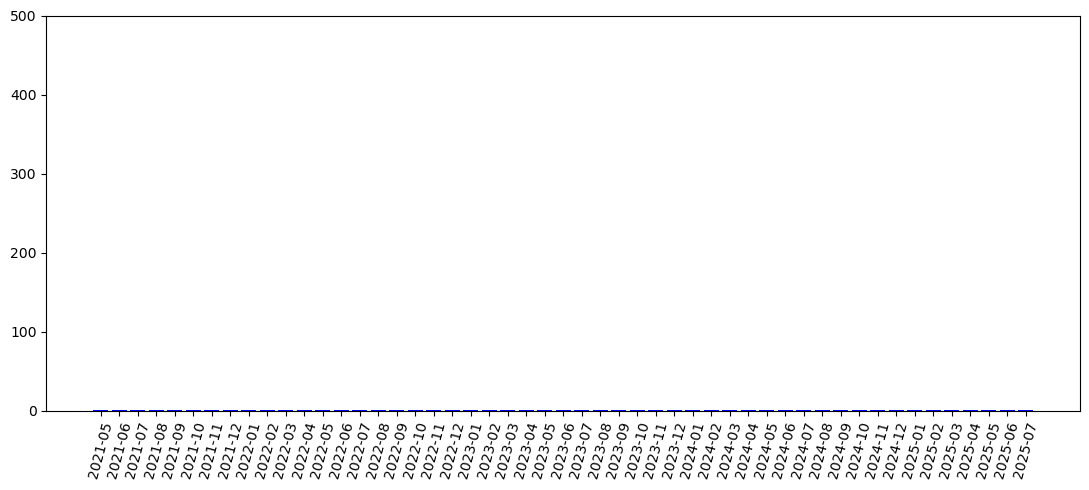

,date,value
0,2021-05,0.231406
1,2021-06,0.212353
2,2021-07,0.218637
3,2021-08,0.215278
4,2021-09,0.213624
5,2021-10,0.226376
6,2021-11,0.201779
7,2021-12,0.176963
8,2022-01,0.182634
9,2022-02,0.154353


In [194]:
temp_df = month_visualize('DistanceWalkingRunning', [0, 500])
temp_df

In [202]:
data[data['type'] == 'HKQuantityTypeIdentifierStepCount'][['startDate', 'value']]

,startDate,value
904015,2024-11-30 21:33:41 +0300,18.0
904016,2024-11-26 18:36:46 +0300,67.0
904017,2024-11-26 19:08:07 +0300,249.0
904018,2024-11-26 19:18:08 +0300,1188.0
904019,2024-11-26 19:28:09 +0300,377.0
...,...,...
1003187,2025-07-23 13:26:09 +0300,577.0
1003188,2025-07-23 13:49:02 +0300,23.0
1003189,2025-07-23 14:14:21 +0300,622.0
1003190,2025-07-23 14:49:40 +0300,16.0


C:\Users\spopo\AppData\Local\Temp\ipykernel_18724\3723178969.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['startDate'].dt.to_period('M').astype(str)


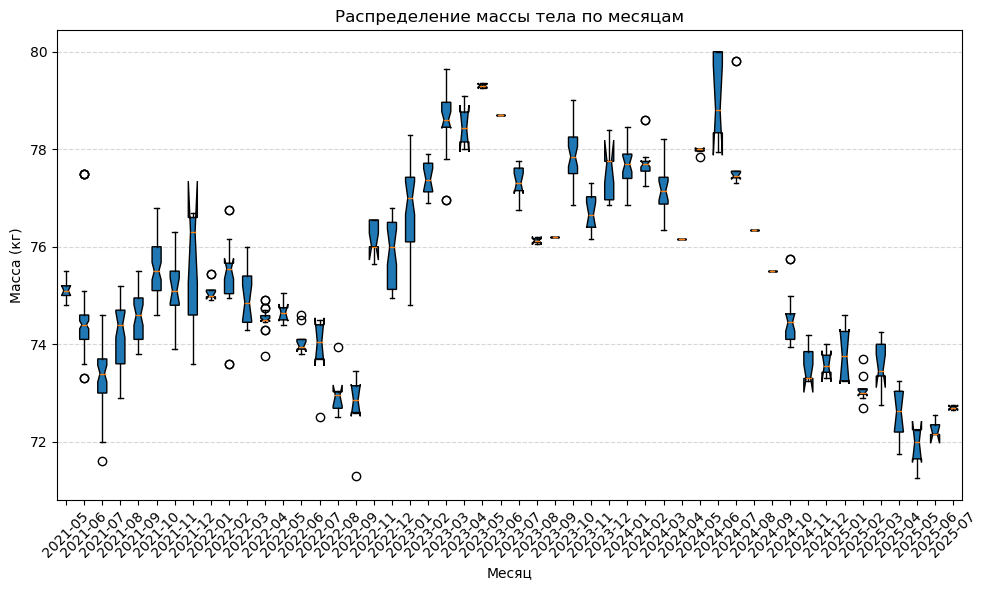

In [36]:
# Cell 3: создаём колонку с месяцем в формате YYYY‑MM
df['month'] = df['startDate'].dt.to_period('M').astype(str)

# Делаем список серий: по одному списку значений веса для каждого месяца
months = sorted(df['month'].unique())
groups = [df.loc[df['month'] == m, 'value'] for m in months]

# Cell 4: рисуем сам boxplot
plt.figure(figsize=(10, 6))
plt.boxlot(
    groups,
    labels=months,        # подписи по оси X
    notch=True,           # вырезы «ночи» (для оценки медианы)
    showfliers=True,      # показать выбросы как точки
    patch_artist=True     # закрасить коробки цветом
)
plt.title('Распределение массы тела по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Масса (кг)')
plt.xticks(rotation=45)   # повернуть подписи, чтобы не накладывались
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Объяснение и опции для изменения

df['month'] = df['startDate'].dt.to_period('M')
— превращает дату в период «месяц», например Period('2025-07', 'M'). С помощью .astype(str) получаем '2025-07'.

groups = […]
— список серий (каждый элемент — все измерения веса в данном месяце).

plt.boxplot(...)

notch=True рисует «выемку» вокруг медианы (помогает визуально оценить уровень доверия).

showfliers=False уберёт точки‑выбросы, если они мешают восприятию.

patch_artist=True позволяет залить «коробки» любым цветом (после можно задать box.set_facecolor('skyblue')).

Настройки внешнего вида

figsize=(ширина, высота) — меняет размер холста.

plt.grid(axis='y', ...) — добавляет горизонтальную сетку по оси Y.

rotation для наклона подписей, tight_layout() автоматически подгоняет поля.

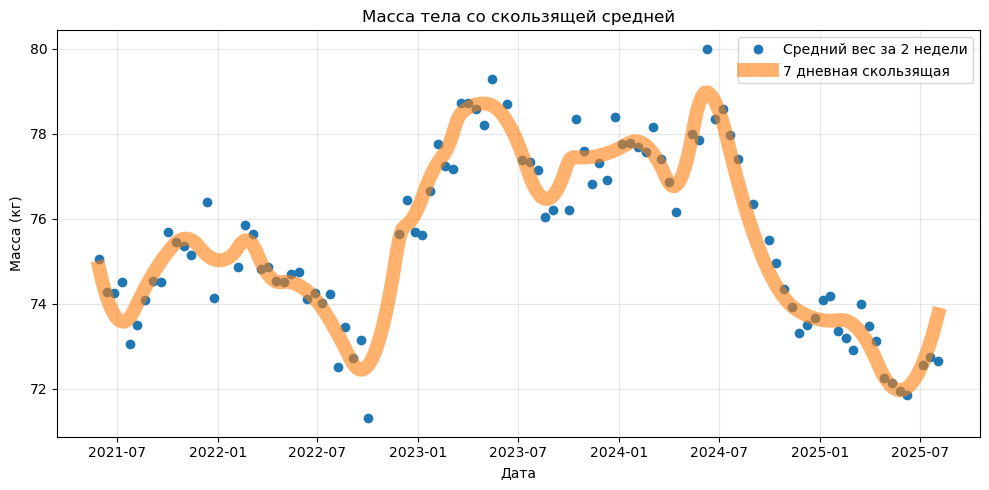

In [74]:
# 2. Агрегация — недельное среднее
weekly = (
    df
    .set_index('startDate')['value']
    .resample('2W')
    .mean()
    .dropna()
)

daily = (
    df
    .set_index('startDate')['value']
    .resample('7D')
    .mean()
    .dropna()
)

# 3. Конвертация дат в числовой формат для сплайна
x = mdates.date2num(weekly.index.to_pydatetime())
y = weekly.values

sx = mdates.date2num(daily.index.to_pydatetime())
sy = daily.values

# 4. Настройка и построение сплайна
#    Параметр s контролирует степень сглаживания:
#    больше s → более гладкая кривая
s_factor = len(x) * np.var(y) * 0.11
spline = UnivariateSpline(sx, sy, s=s_factor, k=2)

# 5. Генерация плотной сетки для гладкой линии
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x_smooth)
dates_smooth = mdates.num2date(x_smooth)

# 6. Визуализация
plt.figure(figsize=(10, 5))
plt.plot(weekly.index.to_pydatetime(), weekly.values, 'o', label='Средний вес за 2 недели')
plt.plot(dates_smooth, y_smooth, label='7 дневная скользящая', linewidth=10, alpha=0.6)
plt.title('Масса тела со скользящей средней')
plt.xlabel('Дата')
plt.ylabel('Масса (кг)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Разница и варианты

resample('7D').mean() будет делить всю шкалу времени на непересекающиеся 7‑дневные «корзины» и считать среднее в каждой.

rolling(window='7D') берёт «скользящее» окно шириной 7 дней для каждой точки на шкале: чаще получается более гладко и непрерывно.

Параметр window можно задавать в днях ('7D'), точках (window=7) или комбинированно (window='2W' для 2 недель).

По умолчанию .rolling(...).mean() включает в окно и центральную точку; есть опция center=True, чтобы окно «центрировалось» вокруг даты, а не «сдвигалось назад».